In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import math
import pandas as pd
from gplearn.tests.test_genetic import *
from gplearn._program import _Program
from gplearn.genetic import _all_func_dictionary, _fitness_map, _extra_fitness_map
from gplearn.extra_fitness import *
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('/home/pennymax/proj/MFM/CrossSection/v1_basic/results/basic_2023-11-22_22:15:18/fct_man_ta_proc.parquet')
df = df.query('time > "2020-09-01 00:00:00+00:00"')
df

,,AR_26,BCKRET1_ALMA_10_6.0_0.85,BCKRET1_ANGLEd_1,BCKRET1_APO_12_26,BCKRET1_BIAS_SMA_26,BCKRET1_CFO_9,BCKRET1_CG_10,BCKRET1_CMO_14,BCKRET1_COPC_11_14_10,BCKRET1_CTI_12,...,premIdx_close,premIdx_high,premIdx_low,premIdx_open,spot_QuoVol,spot_TakerBuyQuoVol,spotum_quo_rt1,spotum_quo_rt3,spotum_quo_rt5,fwdret1
time,symbol,,,,,,,,,,,,,,,,,,,,,
2022-02-15 00:00:00+00:00,1000BTTCUSDT,0.301435,0.275936,-0.488968,0.771073,-1.161410,0.358964,-0.067306,0.607884,-0.221017,0.085637,...,0.654780,1.305227,-1.578736,0.773644,-0.286571,-0.290574,-1.698317,-1.750555,-1.797949,0.006381
2022-02-15 08:00:00+00:00,1000BTTCUSDT,0.203825,0.346633,-0.102897,0.670855,-0.063863,-0.128800,-0.200930,-0.632266,-0.184119,-0.056086,...,0.654619,1.852459,-2.511996,-3.652448,-0.281280,-0.280721,-1.825539,-1.865662,-1.797600,0.005435
2022-02-15 16:00:00+00:00,1000BTTCUSDT,0.109859,0.194290,-0.281913,-0.625057,-0.035205,-0.048292,-0.183299,-0.913829,-0.256562,-0.479517,...,0.429367,1.520373,-0.490996,0.573695,-0.311542,-0.305104,-1.896369,-1.871790,-1.849618,-0.001351
2022-02-16 00:00:00+00:00,1000BTTCUSDT,-0.026714,0.305321,0.818629,-0.432105,-0.135898,0.066802,-0.001660,0.009961,-0.201409,-0.858671,...,5.207442,2.838670,-1.876175,0.332018,-0.333334,-0.335837,-1.982989,-1.945231,-1.941199,-0.026613
2022-02-16 08:00:00+00:00,1000BTTCUSDT,-0.038897,0.149609,0.062552,-0.885780,-0.009816,-0.113658,0.227472,-0.964727,-0.254134,-0.789266,...,0.377948,2.072545,-2.015252,0.486841,-0.345787,-0.341323,-1.852673,-2.017361,-1.978387,0.007878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-19 08:00:00+00:00,ZRXUSDT,3.664874,-3.113825,-1.648899,-5.691401,-0.116280,-0.002034,0.123369,-1.341036,0.297297,-0.282686,...,-0.606585,-0.537085,-0.761102,-0.556576,-0.180849,-0.182091,2.612331,1.771783,2.564827,0.031750
2023-11-19 16:00:00+00:00,ZRXUSDT,2.537322,-2.549892,1.657452,-3.906109,0.200481,0.048510,0.013754,-0.415205,0.089457,0.273883,...,-1.876145,-1.285125,-0.262280,-0.726266,-0.179718,-0.181448,3.599520,1.947164,2.446037,-0.007005
2023-11-20 00:00:00+00:00,ZRXUSDT,2.659109,-2.900207,-0.704719,-3.857578,-3.198881,0.147065,-0.106040,-0.386359,-0.024935,0.805087,...,-1.187991,-0.596983,-0.625408,-2.571711,-0.198680,-0.209446,2.944125,3.235569,2.244819,0.010330


In [4]:
df.sort_index().reset_index()['time'].unique()

<DatetimeArray>
['2020-09-01 08:00:00+00:00', '2020-09-01 16:00:00+00:00',
 '2020-09-02 00:00:00+00:00', '2020-09-02 08:00:00+00:00',
 '2020-09-02 16:00:00+00:00', '2020-09-03 00:00:00+00:00',
 '2020-09-03 08:00:00+00:00', '2020-09-03 16:00:00+00:00',
 '2020-09-04 00:00:00+00:00', '2020-09-04 08:00:00+00:00',
 ...
 '2023-11-17 16:00:00+00:00', '2023-11-18 00:00:00+00:00',
 '2023-11-18 08:00:00+00:00', '2023-11-18 16:00:00+00:00',
 '2023-11-19 00:00:00+00:00', '2023-11-19 08:00:00+00:00',
 '2023-11-19 16:00:00+00:00', '2023-11-20 00:00:00+00:00',
 '2023-11-20 08:00:00+00:00', '2023-11-20 16:00:00+00:00']
Length: 3527, dtype: datetime64[ns, UTC]

<Axes: xlabel='time'>

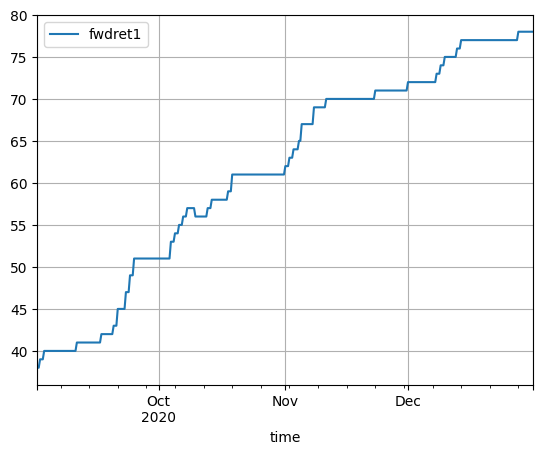

In [5]:
df = df.sort_index()
df[['fwdret1']].groupby('time').fwdret1.count().to_frame().query('time < "2021-01-01 00:00:00+00:00"').plot(grid=True)

In [6]:
def _get_X_y(df):
    df = df.sort_index()
    display(df)
    dfX = df.drop(columns=[col for col in df.columns if col.startswith('fwdret')])
    feature_names = list(dfX.columns)
    dfX = dfX.unstack()
    display(dfX)
    X = dfX.values.reshape(len(dfX), len(feature_names), -1)

    y = df[['fwdret1']].unstack().to_numpy()
    display(df[['fwdret1']].unstack())
    print(X.shape, y.shape, len(feature_names))
    return X, y, feature_names

def convert_expression_to_gp_program(expression: str, function_set: dict, feature_names: list) -> _Program:
    ## convert expression to list function obj and feature index
    tokens = re.findall(r'[\w.]+|\(|\)|,', expression)
    tokens = [t for t in tokens if t not in ['(', ')', ',']]
    # print(tokens)
    program = []
    for token in tokens:
        if token in function_set:
            program.append(function_set[token])
        elif token in feature_names:
            program.append(feature_names.index(token))
        elif token.isdigit():
            program.append(int(token))
        elif token.replace('.', '', 1).isdigit():
            program.append(float(token))
        else:
            print(f'!! unknown token found! {token}')
            return None
    # print(program)

    ## get arity dict
    arities = {}
    for function in function_set.values():
        arity = function.arity
        arities[arity] = arities.get(arity, [])
        arities[arity].append(function)

    ## construct _Program obj
    params = {
            'function_set': function_set,
            'arities': arities,
            'n_features': len(feature_names),
            'feature_names': feature_names,
            'init_depth': (2, 6),
            ## must inputs
            'init_method': 'half and half',
            'const_range': (-1.0, 1.0),
            'metric': 'mean absolute error',
            'p_point_replace': 0.05,
            'parsimony_coefficient': 0.1,
            'random_state': check_random_state(415),
            }
    gp = _Program(program=program, **params)
    return gp

In [7]:
X, y, feature_names = _get_X_y(df)

AR_26  BCKRET1_ALMA_10_6.0_0.85  \
time                      symbol                                         
2020-09-01 08:00:00+00:00 ADAUSDT  -0.089670                  0.061960   
                          ALGOUSDT -0.732490                 -1.573658   
                          ATOMUSDT -0.578613                 -0.537103   
                          BANDUSDT  0.799505                 -0.693916   
                          BATUSDT  -0.764695                 -1.606741   
...                                      ...                       ...   
2023-11-20 16:00:00+00:00 YGGUSDT  -0.775226                 -0.889980   
                          ZECUSDT  -0.853582                 -0.363642   
                          ZENUSDT  -0.464960                  0.720718   
                          ZILUSDT  -0.846218                  0.922539   
                          ZRXUSDT   1.615957                 -1.918622   

                                    BCKRET1_ANGLEd_1  BCKRET1_APO_12_26  \
time                      symbol                                          
2020-09-01 08:00:00+00:00 ADAUSDT           0.024680           0.870559   
                          ALGOUSDT         -1.071624          -0.288705   
                          ATOMUSDT         -1.203450          -0.618524   
                          BANDUSDT         -1.763690          -0.073531   
                          BATUSDT           0.010840           0.038563   
...                                              ...                ...   
2023-11-20 16:00:00+00:00 YGGUSDT           0.929694           0.259135   
                          ZECUSDT           0.136660          -0.188729   
                          ZENUSDT          -0.691563           0.551923   
                          ZILUSDT           0.896855           0.495142   
                          ZRXUSDT           0.045286          -0.903863   

                                    BCKRET1_BIAS_SMA_26  BCKRET1_CFO_9  \
time                      symbol                                         
2020-09-01 08:00:00+00:00 ADAUSDT             -0.252265      -0.028711   
                          ALGOUSDT            -0.158314      -0.075956   
                          ATOMUSDT            -0.154009      -0.160919   
                          BANDUSDT            -0.164386       4.131697   
                          BATUSDT             -0.155096      -0.162955   
...                                                 ...            ...   
2023-11-20 16:00:00+00:00 YGGUSDT             -0.067558       0.545094   
                          ZECUSDT             -0.063572      -0.021144   
                          ZENUSDT             -0.064661      -0.072191   
                          ZILUSDT             -0.069007       0.075574   
                          ZRXUSDT             -0.067730       0.114878   

                                    BCKRET1_CG_10  BCKRET1_CMO_14  \
time                      symbol                                    
2020-09-01 08:00:00+00:00 ADAUSDT        0.210913       -0.866299   
                          ALGOUSDT       0.045543       -0.339730   
                          ATOMUSDT       0.367079       -0.679278   
                          BANDUSDT       0.391188        0.394206   
                          BATUSDT        0.281329       -0.925072   
...                                           ...             ...   
2023-11-20 16:00:00+00:00 YGGUSDT        0.071776        0.817900   
                          ZECUSDT        0.022128       -0.175453   
                          ZENUSDT       -0.011177       -0.802206   
                          ZILUSDT        0.042398        0.949421   
                          ZRXUSDT        0.040858        0.683709   

                                    BCKRET1_COPC_11_14_10  BCKRET1_CTI_12  \
time                      symbol                                            
2020-09-01 08:00:00+00:00 ADAUSDT               -4.840000        0.175571   
        

AR_26                             \
symbol                    1000BTTCUSDT 1000FLOKIUSDT 1000LUNCUSDT   
time                                                                
2020-09-01 08:00:00+00:00          NaN           NaN          NaN   
2020-09-01 16:00:00+00:00          NaN           NaN          NaN   
2020-09-02 00:00:00+00:00          NaN           NaN          NaN   
2020-09-02 08:00:00+00:00          NaN           NaN          NaN   
2020-09-02 16:00:00+00:00          NaN           NaN          NaN   
...                                ...           ...          ...   
2023-11-19 08:00:00+00:00          NaN      1.209876    -0.017766   
2023-11-19 16:00:00+00:00          NaN      1.010284     0.338275   
2023-11-20 00:00:00+00:00          NaN      1.322188     0.108759   
2023-11-20 08:00:00+00:00          NaN      1.409624    -0.072293   
2023-11-20 16:00:00+00:00          NaN      1.432228    -0.051151   

                                                                           \
symbol                    1000PEPEUSDT 1000SHIBUSDT 1000XECUSDT 1INCHUSDT   
time                                                                        
2020-09-01 08:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-01 16:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-02 00:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-02 08:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-02 16:00:00+00:00          NaN          NaN         NaN       NaN   
...                                ...          ...         ...       ...   
2023-11-19 08:00:00+00:00    -0.209249    -0.177718   -0.297947 -0.717730   
2023-11-19 16:00:00+00:00    -0.115461    -1.104164   -0.161770 -0.614664   
2023-11-20 00:00:00+00:00    -0.081292    -0.822623         NaN -0.718813   
2023-11-20 08:00:00+00:00    -0.060273    -0.783898         NaN -0.808086   
2023-11-20 16:00:00+00:00    -0.320948    -0.711968         NaN -0.660667   

                                                         ... spotum_quo_rt5  \
symbol                     AAVEUSDT   ACHUSDT   ADAUSDT  ...        XTZUSDT   
time                                                     ...                  
2020-09-01 08:00:00+00:00       NaN       NaN -0.089670  ...       0.145786   
2020-09-01 16:00:00+00:00       NaN       NaN  0.013180  ...       0.057434   
2020-09-02 00:00:00+00:00       NaN       NaN  0.000518  ...      -0.018889   
2020-09-02 08:00:00+00:00       NaN       NaN  0.025769  ...       0.089268   
2020-09-02 16:00:00+00:00       NaN       NaN  0.066340  ...       0.068500   
...                             ...       ...       ...  ...            ...   
2023-11-19 08:00:00+00:00 -0.483983 -1.118874 -0.376072  ...       1.142127   
2023-11-19 16:00:00+00:00 -0.265661 -1.035463 -0.308242  ...       1.128182   
2023-11-20 00:00:00+00:00 -0.297778 -0.914690 -0.287269  ...       1.262307   
2023-11-20 08:00:00+00:00 -0.317431 -0.633697 -0.123666  ...       1.516744   
2023-11-20 16:00:00+00:00 -0.350808 -0.555673 -0.209878  ...       1.616295   

                                                                            \
symbol                      XVGUSDT   XVSUSDT YFIIUSDT   YFIUSDT   YGGUSDT   
time                                                                         
2020-09-01 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-01 16:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-02 00:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-02 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-02 16:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
...                             ...       ...      ...       ...       ...   
2023-11-19 08:00:00+00:00 -0.385045 -0.761242      NaN  1.458027 -0.171629   
2023-11-19 16:00:00+00:00 -0.516774 -0.753067      NaN  1.743364 -0.164711   
2023-11-20 00:00:00+00

fwdret1                             \
symbol                    1000BTTCUSDT 1000FLOKIUSDT 1000LUNCUSDT   
time                                                                
2020-09-01 08:00:00+00:00          NaN           NaN          NaN   
2020-09-01 16:00:00+00:00          NaN           NaN          NaN   
2020-09-02 00:00:00+00:00          NaN           NaN          NaN   
2020-09-02 08:00:00+00:00          NaN           NaN          NaN   
2020-09-02 16:00:00+00:00          NaN           NaN          NaN   
...                                ...           ...          ...   
2023-11-19 08:00:00+00:00          NaN      0.042844     0.019783   
2023-11-19 16:00:00+00:00          NaN     -0.006086    -0.005396   
2023-11-20 00:00:00+00:00          NaN     -0.015003    -0.005812   
2023-11-20 08:00:00+00:00          NaN     -0.037302    -0.018189   
2023-11-20 16:00:00+00:00          NaN      0.000000     0.000000   

                                                                           \
symbol                    1000PEPEUSDT 1000SHIBUSDT 1000XECUSDT 1INCHUSDT   
time                                                                        
2020-09-01 08:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-01 16:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-02 00:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-02 08:00:00+00:00          NaN          NaN         NaN       NaN   
2020-09-02 16:00:00+00:00          NaN          NaN         NaN       NaN   
...                                ...          ...         ...       ...   
2023-11-19 08:00:00+00:00     0.046193     0.018771    0.022207  0.033277   
2023-11-19 16:00:00+00:00     0.010577     0.000000    0.000000 -0.009552   
2023-11-20 00:00:00+00:00    -0.009220    -0.008752         NaN -0.004133   
2023-11-20 08:00:00+00:00    -0.051727    -0.020562         NaN -0.014388   
2023-11-20 16:00:00+00:00     0.000000     0.000000         NaN  0.000000   

                                                         ...            \
symbol                     AAVEUSDT   ACHUSDT   ADAUSDT  ...   XTZUSDT   
time                                                     ...             
2020-09-01 08:00:00+00:00       NaN       NaN  0.022895  ...  0.031699   
2020-09-01 16:00:00+00:00       NaN       NaN -0.024228  ... -0.037391   
2020-09-02 00:00:00+00:00       NaN       NaN -0.069473  ... -0.082806   
2020-09-02 08:00:00+00:00       NaN       NaN  0.016434  ...  0.031188   
2020-09-02 16:00:00+00:00       NaN       NaN -0.010605  ... -0.033747   
...                             ...       ...       ...  ...       ...   
2023-11-19 08:00:00+00:00  0.030054  0.041865  0.018563  ...  0.018980   
2023-11-19 16:00:00+00:00  0.007977  0.002543  0.008592  ...  0.000000   
2023-11-20 00:00:00+00:00 -0.005312  0.018772  0.012390  ...  0.004657   
2023-11-20 08:00:00+00:00 -0.016022 -0.010956 -0.029577  ... -0.023175   
2023-11-20 16:00:00+00:00  0.000000  0.000000  0.000000  ...  0.000000   

                                                                            \
symbol                      XVGUSDT   XVSUSDT YFIIUSDT   YFIUSDT   YGGUSDT   
time                                                                         
2020-09-01 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-01 16:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-02 00:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-02 08:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
2020-09-02 16:00:00+00:00       NaN       NaN      NaN       NaN       NaN   
...                             ...       ...      ...       ...       ...   
2023-11-19 08:00:00+00:00  0.023442  0.021856      NaN -0.039369  0.058414   
2023-11-19 16:00:00+00:00 -0.013687 -0.021813      NaN  0.019586 -0.015949   
2023-11-20 00:00:00+00:00 -0.003682  0.049812      NaN -0.010437 -0.005403   
2023-11-20 0

(3527, 1116, 237) (3527, 237) 1116


In [21]:
exp = 'sub(mul(BCKRET1_MOM_5, SPOTVOLUME_TSIs_13_25_13), premIdx_close)'
exp = 'sub(SPOT_COPC_11_14_10, ts_correlation_20(SPOTTAKERBUYQUOVOL_PPOh_12_26_9, TRDCNT_TSI_13_25_13))'
exp = 'inv(rank(TZS60_spot_Close))'
exp = 'ts_mean_20(inv(inv(TZS60_spot_Close)))'
exp = 'min(NETBUYQUO1_FWMA_10, ts_min_10(TZS60_SPOT_HLC3))'
# exp = 'neg(add(premIdx_close, max(TZS60_VOLUME_PPO_12_26_9, PREMCLOSE_MACDs_12_26_9)))'
# exp = 'sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close))'
# exp = 'netbuyquo3'
# exp = 'sub(netbuyquo3, premIdx_close)'
# exp = 'sub(ts_min_10(TZS60_spot_Close), premIdx_close)'
# exp = 'min(NETBUYQUO1_JMA_7_0, ts_min_10(SMI_5_20_5))'
# exp = 'min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2))'
# exp = 'max(min(netbuyquo3, bckret3), netbuyquo5)'
exp = 'add(sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close)), min(NETBUYQUO5_DEMA_10, ts_min_10(TZS60_SPOT_HL2)))'
# exp = 'add(sub(min(ts_mean_10(bckret1), netbuyquo3), max(ts_min_3(QuoVol), premIdx_close)), max(min(netbuyquo3, bckret3), netbuyquo5)'
# exp = 'min(ts_min_10(TZS60_SPOT_HLC3), J_9_3)'
# exp = 'min(NETBUYQUO1_JMA_7_0, ts_min_10(SMI_5_20_5))'
# exp = 'min(ts_min_3(ts_min_10(TZS60_SPOT_HLC3)), TZS60_MACDh_12_26_9)'
# exp = 'min(ts_min_10(QQE_14_5_4.236_RSIMA), TZS60_BIAS_SMA_26)'
# exp = "add(ts_max_3(TZS60_ALMA_10_6.0_0.85), netbuyquo3)"
# exp = 'min(delta_5(ts_min_20(ts_mean_10(ts_correlation_3(rank(TZS60_VOLUME_EMA_10), rank(SQZPRO_ON_NORMAL))))), SPOT_PGO_14)'
# exp = 'add(SPOT_COPC_11_14_10, rank(add(NETBUYQUO1_TSIs_13_25_13, NETBUYQUO1_DEMA_10)))'
# exp = 'ts_min_3(delta_5(ts_min_20(ts_mean_10(ts_correlation_3(rank(TZS60_VOLUME_EMA_10), rank(SQZPRO_ON_NORMAL))))))'
# exp = 'ts_min_20(min(TZS60_HWMA_0.2_0.1_0.1, NETBUYQUO3_SMIs_5_20_5))'
# exp = 'add(ts_min_5(UO_7_14_28), NETBUYQUO1_TSI_13_25_13)'
# exp = 'min(ts_mean_3(netbuyquo1), ts_min_5(TZS60_JMA_7_0))'
# exp = 'min(SPOT_CCI_14_0.015, ts_min_10(TZS60_spot_Low))'
# exp = 'min(ts_min_10(QQE_14_5_4.236_RSIMA), J_9_3)'
# exp = 'min(ts_min_10(TZS60_SPOT_HL2), J_9_3)'
# exp = 'neg(SQZPRO_NO)'
exp = 'min(min(TZS60_SMA_10, min(ts_min_10(TZS60_JMA_7_0), J_9_3)), TZS60_SUPERT_7_3.0)'
exp = 'min(min(NETBUYQUO1_KAMA_10_2_30, ts_min_10(TZS60_spot_Close)), NETBUYQUO3_SMIs_5_20_5)'
exp = 'min(min(NETBUYQUO1_KAMA_10_2_30, ts_min_10(TZS60_Close)), NETBUYQUO3_SMIs_5_20_5)'
exp = 'min(min(ts_min_10(TZS60_spot_High), NETBUYQUO1_EMA_10), NETBUYQUO5_FWMA_10)'
exp = 'if_cond_then_else(SPOTTAKERBUYQUOVOL_RSX_14, QUOVOL_SMA_10, BCKRET1_SWMA_10, NETBUYQUO5_HMA_10)'


print(f'ori expression: {exp}')
feature_names = df.columns.to_list()
gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')

y_pred = gp.execute_3D(X)

metric_values = []
for metric_name, metric_func in _extra_fitness_map.items():
    metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
    metric_values.append(metric_val)
metric_df = pd.DataFrame(metric_values, index = _extra_fitness_map.keys())
display(metric_df.round(3))

ori expression: if_cond_then_else(SPOTTAKERBUYQUOVOL_RSX_14, QUOVOL_SMA_10, BCKRET1_SWMA_10, NETBUYQUO5_HMA_10)
_Program print: if_cond_then_else(SPOTTAKERBUYQUOVOL_RSX_14, QUOVOL_SMA_10, BCKRET1_SWMA_10, NETBUYQUO5_HMA_10)


,0
rank_ic,-0.005
rank_icir,-0.033
quantile35_longshort_total_return_cumprod_with_fee,4.858
quantile35_longshort_total_return_cumsum_with_fee,2.355
quantile35_longshort_cagr_cumprod_with_fee,0.731
quantile35_longshort_cagr_cumsum_with_fee,0.731
quantile35_longshort_cagr_cumprod,1.533
quantile35_longshort_cagr_cumsum,1.112
quantile35_longshort_sharpe_fine_cumprod_with_fee,0.884
quantile35_longshort_sharpe_fine_cumsum_with_fee,0.884


In [22]:
dfypred = pd.DataFrame(y_pred)
display(dfypred)
display(dfypred.describe())

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117309,...,-0.580823,NaN,NaN,NaN,NaN,NaN,-0.089391,NaN,0.402873,-1.161907
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090811,...,0.072389,NaN,NaN,NaN,NaN,NaN,0.383557,NaN,0.392761,-1.124569
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086849,...,0.122113,NaN,NaN,NaN,NaN,NaN,0.422714,NaN,0.368510,-1.048263
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.827910,...,0.144520,NaN,NaN,NaN,NaN,NaN,0.407619,NaN,0.347590,-0.943660
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.588273,...,0.138859,NaN,NaN,NaN,NaN,NaN,0.373113,NaN,0.330141,0.349557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522,NaN,0.022119,0.069870,-0.327074,-0.762639,0.286932,-0.137943,-0.402573,0.013358,0.325228,...,0.244398,0.255355,-0.213092,NaN,-3.075521,-0.896753,0.160890,0.353942,0.110739,-3.353442
3523,NaN,-0.128524,-0.073241,-0.168847,-0.520832,0.051899,-0.057384,-0.159309,0.022070,0.471457,...,0.133195,0.025387,-0.045874,NaN,-2.666232,-0.534241,-0.032473,0.030719,-0.079986,-2.597751
3524,NaN,-0.128373,-0.097579,-0.122728,-0.361281,NaN,-0.028410,0.032696,-0.057687,0.581175,...,-0.032711,-0.047717,0.008878,NaN,-6.591785,-0.264849,-0.072725,-0.043670,-0.116596,-1.934479
3525,NaN,-0.110278,-0.091790,-0.156101,-0.347555,NaN,-0.030716,0.119598,-0.069417,0.495255,...,-0.166172,-0.060850,-0.012830,NaN,-5.245401,0.078404,-0.075331,-0.062123,-0.122349,-1.280518


,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
count,167.000000,535.000000,1253.000000,538.000000,2713.000000,2322.000000,3122.000000,3333.000000,755.000000,3527.000000,...,3527.000000,356.000000,606.000000,1700.000000,3471.000000,264.000000,3527.000000,3216.000000,3527.000000,3527.000000
mean,0.000964,0.107869,-0.112322,-0.134305,-0.078694,0.051719,-0.131170,-0.107222,-0.168087,-0.266100,...,-0.089193,-0.313781,-0.106576,-0.109083,-0.105816,-0.323112,-0.067199,-0.059128,-0.080144,-0.074231
std,0.497848,0.926842,0.691942,1.470237,1.119286,0.600270,0.498123,0.452168,0.516307,0.640246,...,0.416805,0.689466,0.523018,0.597004,0.586630,0.639885,0.430095,0.486012,0.577237,0.490782
min,-1.005618,-1.920498,-3.381386,-5.103699,-3.111338,-2.880890,-6.689962,-2.260822,-2.468220,-5.882574,...,-2.843687,-3.764265,-3.232049,-3.029956,-6.591785,-2.811393,-2.291399,-2.876059,-3.404885,-4.288426
25%,-0.425480,-0.109880,-0.323242,-0.853774,-0.541642,-0.119410,-0.282624,-0.347122,-0.304933,-0.549440,...,-0.273553,-0.603679,-0.211874,-0.471483,-0.385065,-0.676105,-0.224645,-0.223838,-0.295518,-0.256184
50%,0.106703,0.058151,-0.092904,-0.272246,-0.212502,0.094567,-0.051807,-0.039224,-0.054180,-0.210740,...,-0.022737,-0.093516,-0.004279,0.049520,-0.039983,-0.158514,0.025151,0.020319,-0.039336,0.005413
75%,0.284951,0.151250,0.085717,0.057554,0.037429,0.221883,0.137758,0.151860,0.120838,0.046834,...,0.160421,0.077616,0.148806,0.294313,0.196777,0.047980,0.189039,0.208283,0.171931,0.219077
max,1.824306,7.073454,5.402888,8.074246,9.717107,8.272119,3.684177,3.645146,1.558220,3.444341,...,2.627930,1.839878,1.358155,2.047151,4.240328,1.701370,2.189453,2.240733,7.879656,3.863936


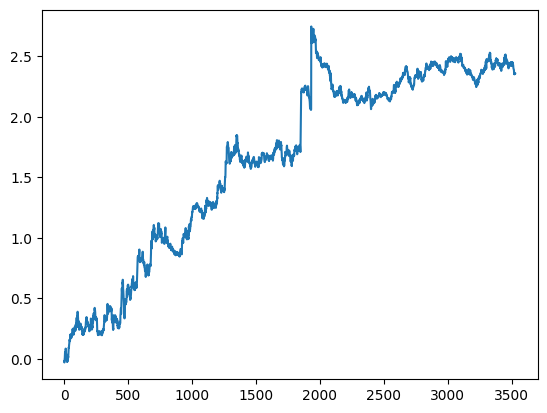

count    3526.000000
mean        0.000344
std         0.000153
min         0.000000
25%         0.000250
50%         0.000333
75%         0.000450
max         0.001000
dtype: float64

0             NaN
1        0.000249
2        0.000495
3        0.000746
4        0.000746
          ...    
3522    11.479067
3523    11.484774
3524    11.493327
3525    11.494753
3526    11.500456
Length: 3527, dtype: float64

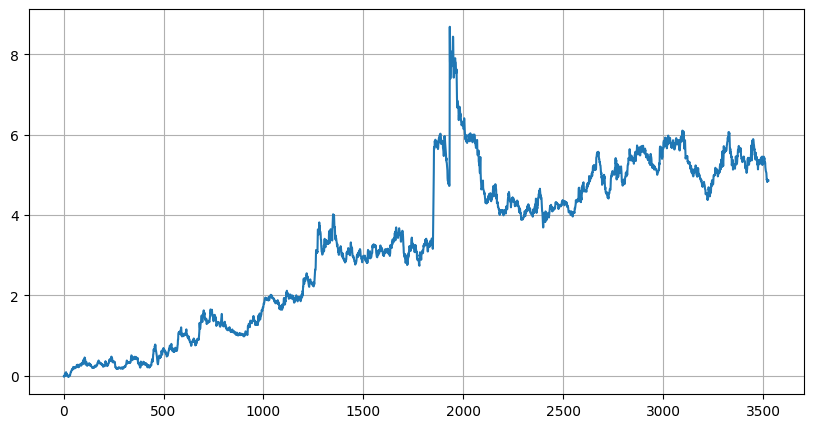

In [23]:
quantile = 35
fee_rate = 0.001
longshort_rets = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, fee_rate)
longshort_rets.cumsum().plot()
plt.show()
longshort_netval = longshort_rets.add(1).cumprod()
longshort_netval.sub(1).plot(figsize=(10, 5), grid=True)

longshort_rets_nofee = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, 0)
longshort_netval_nofee = longshort_rets_nofee.add(1).cumprod()
# longshort_netval_nofee.sub(1).plot(figsize=(10, 5), grid=True)

grouped_returns, factor_quantiles = quantile_returns_and_groups(y, y_pred, quantile)
longshort_fee = calc_longshort_fee(factor_quantiles, quantile, fee_rate)
display(longshort_fee.describe())
cumfee = longshort_netval_nofee.mul(longshort_fee).cumsum()
display(cumfee)
# longshort_netval_nofee.sub(1).sub(cumfee).plot(grid=True)


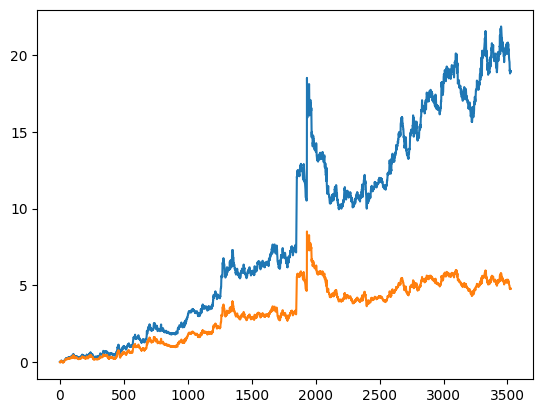

In [24]:
quantile = 35
fee_rate = 0.001

longshort_rets_nofee = quantile_longshort_returns(y, y_pred, np.ones(X.shape[0]), quantile, 0)
longshort_rets_nofee.add(1).cumprod().sub(1).plot()
longshort_netval_nofee = longshort_rets_nofee.add(1)

longshort_fee = calc_longshort_fee(factor_quantiles, quantile, fee_rate)
longshort_netval_fee = longshort_netval_nofee.mul(0.99).add(0.01 - 0.99 * longshort_fee).cumprod().sub(1)
# longshort_netval_fee = longshort_netval_nofee.mul(0.99).add(0.01).cumprod().sub(1)
longshort_netval_fee.plot()

longshort_netval_fee2 = longshort_rets_nofee.sub(longshort_fee).add(1).cumprod().sub(1)
# longshort_netval_fee2.plot()

,1,35,ls
0,0.018685,0.008395,0.013540
1,0.014524,-0.052616,-0.019046
2,0.064050,-0.080982,-0.008466
3,-0.002341,0.038349,0.018004
4,0.026655,-0.003950,0.011353
...,...,...,...
3522,-0.025002,0.011839,-0.006582
3523,0.005006,0.005043,0.005024
3524,0.006275,-0.008101,-0.000913
3525,0.035397,-0.035156,0.000120


,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,...,7,NaN,NaN,NaN,NaN,NaN,13,NaN,26,2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,...,14,NaN,NaN,NaN,NaN,NaN,26,NaN,27,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,...,17,NaN,NaN,NaN,NaN,NaN,30,NaN,24,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,...,15,NaN,NaN,NaN,NaN,NaN,31,NaN,24,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,...,16,NaN,NaN,NaN,NaN,NaN,30,NaN,24,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522,NaN,15,17,8,3,29,11,7,14,32,...,24,25,10,NaN,1,2,20,33,17,1
3523,NaN,12,14,11,4,28,15,12,22,34,...,31,23,15,NaN,1,4,16,24,14,1
3524,NaN,13,15,14,6,NaN,28,31,20,35,...,26,22,31,NaN,1,9,18,23,14,1
3525,NaN,15,18,13,7,NaN,29,33,21,35,...,12,22,30,NaN,1,32,19,22,14,1


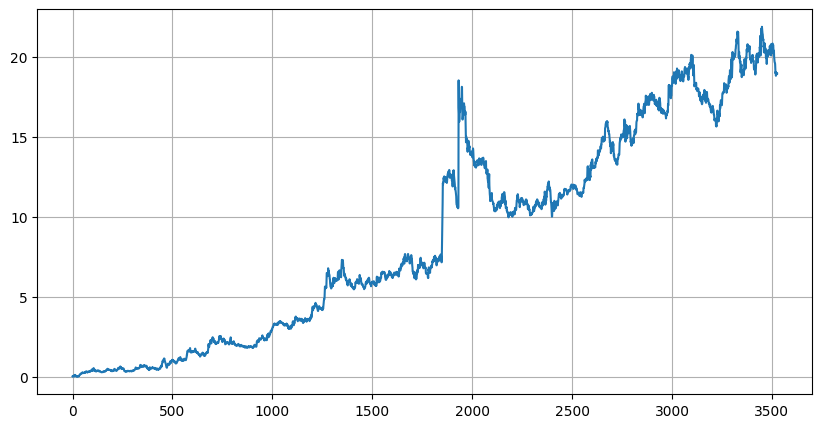

In [25]:
def compute_quantile_rets_2(y, y_pred, w, quantiles):
    y_pred = y_pred[w.astype(bool)]
    y = y[w.astype(bool)]
    if np.all(np.isnan(y_pred)):
        return None, None
    
    rets = pd.DataFrame(y)
    factor = pd.DataFrame(y_pred)

    ## use y (return) to mask y_pred to set 0 on all invaid cells to nan
    factor = factor.mask(rets.isna())
    
    groups = np.array(range(quantiles)) + 1
    
    try:
        factor_quantiles = (
            factor
            .rank(axis=1, method='first') # method first means assign different ranks on identical values
            .dropna(axis=0, how='all')
            .apply(pd.qcut, q=quantiles, labels=groups, axis=1, duplicates='drop')
        )
    except:
        print('here')
        return None, None
    
    stacked_rets = rets.stack()
    stacked_factor_quantiles = factor_quantiles.stack()
    grouped_returns = (
        stacked_rets
        .groupby([stacked_rets.index.get_level_values(0), stacked_factor_quantiles])
        .mean()
        .unstack()
        ) 
    return grouped_returns, factor_quantiles

grouped_returns, factor_quantiles = compute_quantile_rets_2(y, y_pred, np.ones(X.shape[0]), 35)
grouped_returns = grouped_returns[[1, 35]]
grouped_returns[1] = grouped_returns[1].mul(-1)
grouped_returns['ls'] = (grouped_returns[35] + grouped_returns[1]) / 2
display(grouped_returns)
grouped_returns.ls.add(1).cumprod().sub(1).plot(figsize=(10, 5), grid=True)
display(factor_quantiles)

In [26]:
grouped_returns

,1,35,ls
0,0.018685,0.008395,0.013540
1,0.014524,-0.052616,-0.019046
2,0.064050,-0.080982,-0.008466
3,-0.002341,0.038349,0.018004
4,0.026655,-0.003950,0.011353
...,...,...,...
3522,-0.025002,0.011839,-0.006582
3523,0.005006,0.005043,0.005024
3524,0.006275,-0.008101,-0.000913
3525,0.035397,-0.035156,0.000120


(12.766160537996084, 438.06879645559053, 0.4805783952367451)

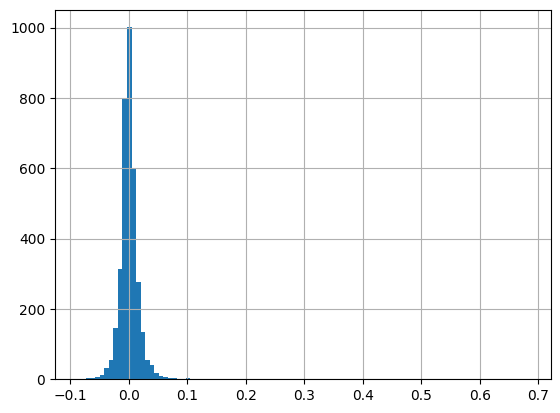

In [27]:
longshort_rets.hist(bins=100)
longshort_rets.skew(), longshort_rets.kurt(), longshort_rets[longshort_rets > 0].count() / longshort_rets.shape[0]

In [28]:
longshort_rets

0            NaN
1      -0.019296
2      -0.008716
3       0.017754
4       0.011353
          ...   
3522   -0.006939
3523    0.004739
3524   -0.001342
3525    0.000049
3526   -0.000286
Length: 3527, dtype: float64

rolling_sharpe_sharpe: 0.39898421518382177
slope: -0.0004778609831629302
radians: -0.0004778609467895717
degrees: -0.027379415445168063


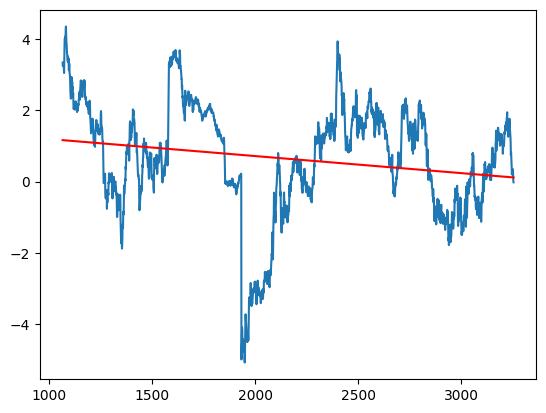

In [29]:
window = int(annual_bar_8h/4)
rolling_sharpe = longshort_rets.rolling(window).mean() / longshort_rets.rolling(window).std() * np.sqrt(annual_bar_8h)
rolling_sharpe = rolling_sharpe.dropna().reset_index(drop=True).iloc[-365*3*2:]
rolling_sharpe_sharpe = rolling_sharpe.mean() / rolling_sharpe.std()
print('rolling_sharpe_sharpe:', rolling_sharpe_sharpe)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
XX = rolling_sharpe.index.values.reshape(-1, 1)
model = lr.fit(XX, rolling_sharpe.values)
slope = model.coef_[0]
angle_radians = math.atan(slope)
angle_degrees = angle_radians * 180 / math.pi
print('slope:', slope)
print('radians:', angle_radians)
print('degrees:', angle_degrees)

rolling_sharpe.plot()
y_pred2 = model.predict(XX)
plt.plot(XX, y_pred2, color='red')
plt.show()